In [4]:
# pwd is /content
cd /content/drive/My Drive/deep-learning-v2-pytorch/style-transfer

/content/drive/My Drive/deep-learning-v2-pytorch/style-transfer


In [2]:
# import resources
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

vgg = models.vgg19(pretrained = True).features

for params in vgg.parameters() :
  params.requires_grad = False
vgg.to('cuda')

def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
        
    image = Image.open(img_path)
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    return image

def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    ## get the batch_size, depth, height, and width of the Tensor
    ## reshape it, so we're multiplying the features for each channel
    ## calculate the gram matrix
    batch_size, d, h, w = tensor.size()
    gram = tensor.permute(1,0,2,3).view(d, -1)
    gram = torch.mm(gram, gram.t())
    return gram 

# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [0]:

# load in content and style image
content = load_image('images/space_needle.jpg').to('cuda')
# Resize style to match content, makes code easier
style = load_image('images/night.jpg', shape=content.shape[-2:]).to('cuda')
#initialy target image is same as content image
target = content.clone().requires_grad_(True)

def get_features(image, model, layers=None):

    if layers is None:
        layers = {'0': 'conv1_1',
                   '5': 'conv2_1',
                   '10': 'conv3_1',
                   '19':'conv4_1',
                   '28':'conv5_1',
                   '21':'conv4_2' #content
                  }
        
        
    ## -- do not need to change the code below this line -- ##
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features



In [0]:

content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [0]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}


In [0]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1,
                 'conv2_1': 0.5,
                 'conv3_1': 0.4,
                 'conv4_1': 0.4,
                 'conv5_1': 0.4}

# you may choose to leave these as is
content_weight = 1  # alpha
style_weight = 1e5  # beta

Total loss:  4.733904212533759e+20


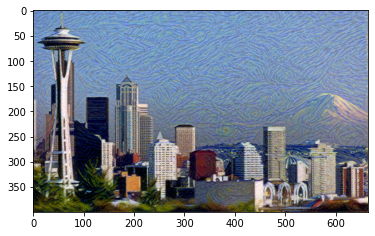

Total loss:  2.6978769587297845e+20


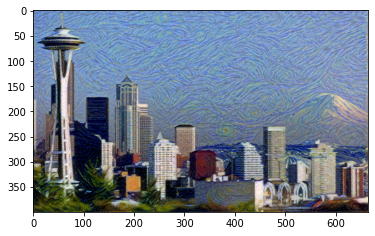

Total loss:  2.0281012703035235e+20


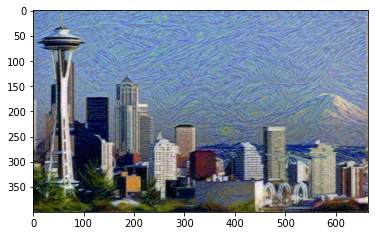

Total loss:  1.583030926066309e+20


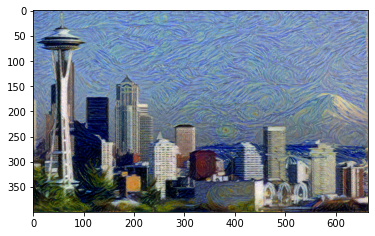

Total loss:  1.3342688831880351e+20


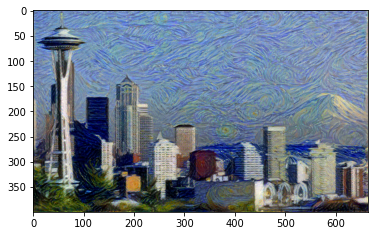

Total loss:  1.1521759477622846e+20


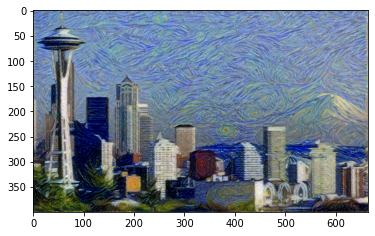

Total loss:  1.0355358840068768e+20


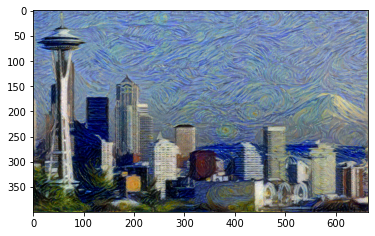

Total loss:  9.446630071897948e+19


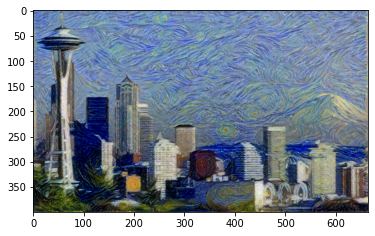

Total loss:  8.989934283357002e+19


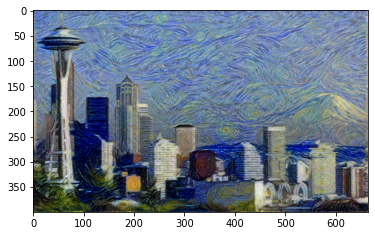

Total loss:  8.77709346128003e+19


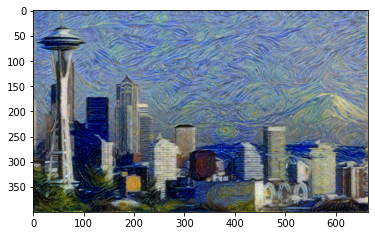

Total loss:  8.844714305997557e+19


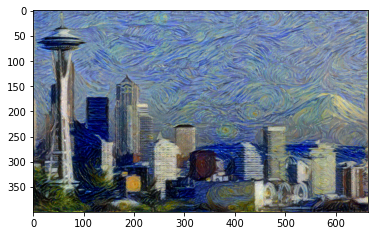

Total loss:  8.310154622414723e+19


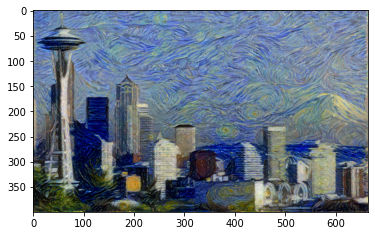

Total loss:  7.389897694728998e+19


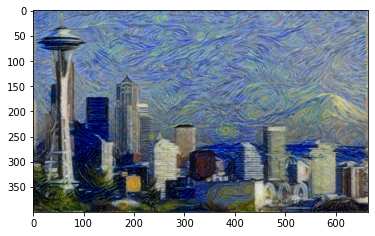

Total loss:  7.130473203811064e+19


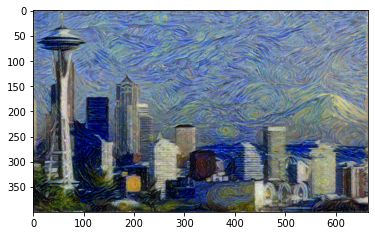

Total loss:  7.085428851248988e+19


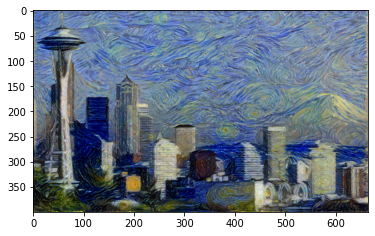

Total loss:  6.767114077742721e+19


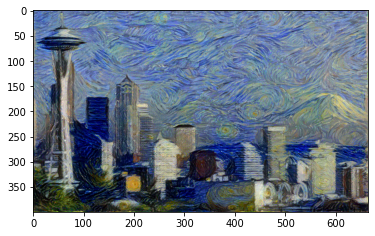

Total loss:  6.661931716797111e+19


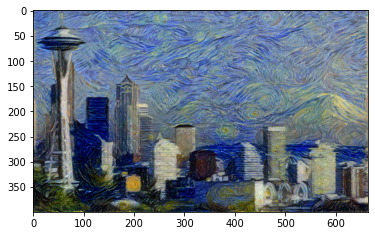

Total loss:  1.2808445807646317e+20


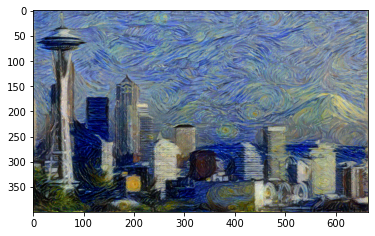

Total loss:  6.371834809706086e+19


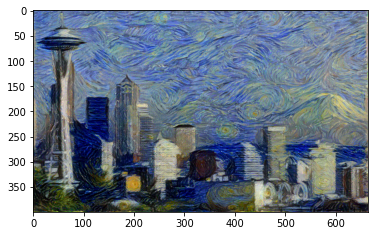

Total loss:  6.583430544815764e+19


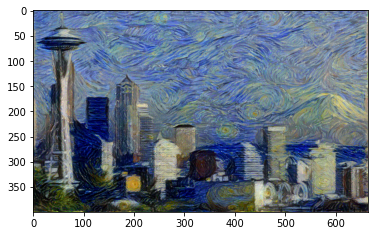

Total loss:  5.964882686424331e+19


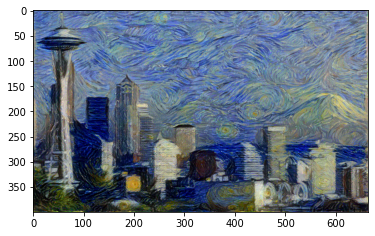

Total loss:  6.093305204743917e+19


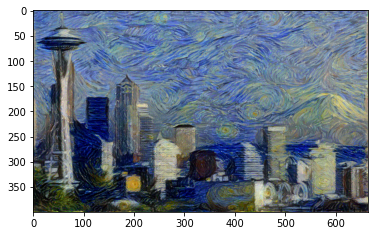

Total loss:  6.153247939862358e+19


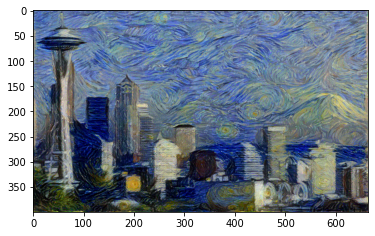

Total loss:  5.8297557860032184e+19


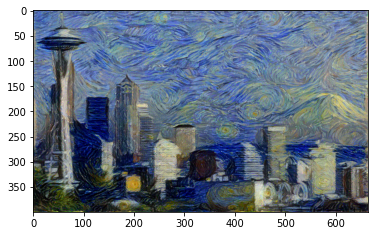

Total loss:  5.781861939106598e+19


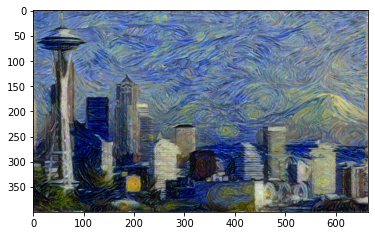

Total loss:  6.538630723639706e+19


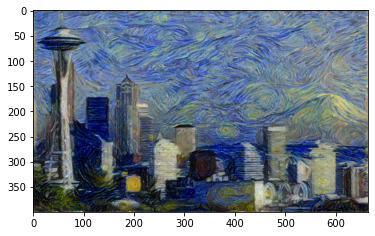

Total loss:  5.555113614352214e+19


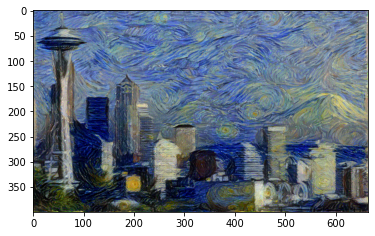

Total loss:  5.808333781056933e+19


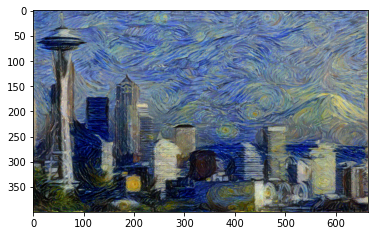

Total loss:  5.965803637363756e+19


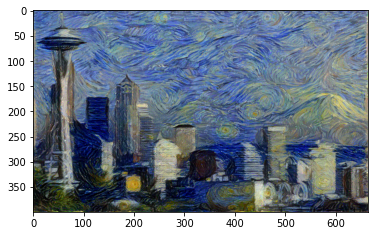

Total loss:  6.54232772153694e+19


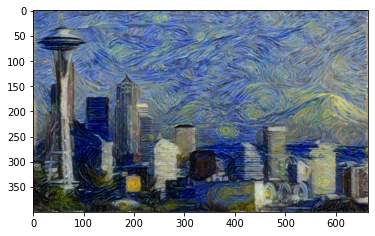

KeyboardInterrupt: ignored

In [10]:

# for displaying the target image, intermittently
show_every = 1000

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.01)
steps = 50000 

for ii in range(1, steps+1):
    
    
    ## TODO: get the features from your target image    
    ## Then calculate the content loss
    target_features = get_features(target, vgg)
    a, b = target_features['conv4_2'], content_features['conv4_2'] 
    content_loss = 0.5 * torch.mean( ( a- b )**2)

    style_loss = 0

    for layer in style_weights:
      target_gram = gram_matrix( target_features[layer] )
      x, y = target_gram.size()
      style_loss += (1.0/4*x*x*y*y) * style_weights[layer]* torch.mean( (target_gram - style_grams[layer])**2 )
      

    # for layer in style_weights:
    #   x, y = style_grams[layer].size()
    #   sloss += (1.0/x*y) * style_weights[layer] * torch.mean(style_grams[layer])

    # for layer in style_weights:
    #   x, y = target_grams[layer].size()
    #   tloss += (1.0/x*y) * style_weights[layer] * torch.mean(target_grams[layer])

    # style_loss = (sloss - tloss)**2

    total_loss = content_weight * content_loss + style_weight * style_loss


    ## -- do not need to change code, below -- ##
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

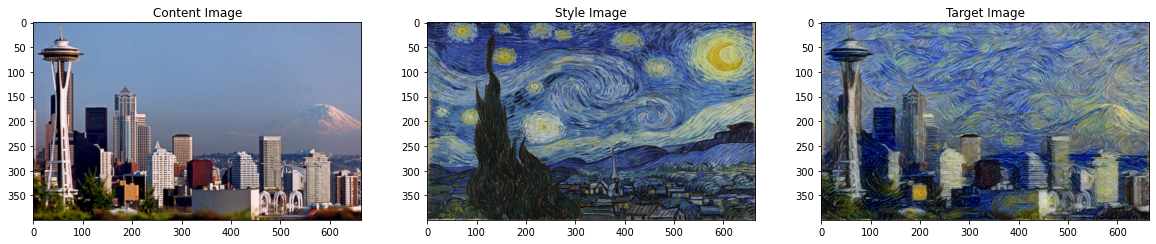

In [11]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.set_title('Content Image')
ax1.imshow(im_convert(content))
ax2.set_title('Style Image')
ax2.imshow(im_convert(style))
ax3.set_title('Target Image')
ax3.imshow(im_convert(target))